<a href="https://colab.research.google.com/github/Ofiregev/Final_Project-FetalCns/blob/main/Fetal_Cns_Final_reg_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler

In [53]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [55]:
# Read CSV file
train_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC.csv"
train_csv_df = pd.read_csv(train_csv)
print("CSV file loaded:")

CSV file loaded:


In [56]:
# Image Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:
# Normalize the labels in the dataset
min_hc = train_csv_df['head circumference (mm)'].min()
max_hc = train_csv_df['head circumference (mm)'].max()
train_csv_df['Normalized_HC'] = (train_csv_df['head circumference (mm)'] - min_hc) / (max_hc - min_hc)
output_csv = "/content/drive/MyDrive/FinalProject/training_set_pixel_size_and_HC_no_index.csv"
train_csv_df.to_csv(output_csv, index=False)
print("Normalized CSV file saved.")

Normalized CSV file saved.


In [58]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        hc = self.data_frame.iloc[idx, -1]  # Normalized head circumference

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(hc, dtype=torch.float)

In [70]:
# Dataset and DataLoader
csv_file = output_csv
root_dir = "/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/"
dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [71]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, 1)
        )

    def forward(self, x):
        return self.model(x)

In [72]:
from torch.optim.lr_scheduler import StepLR

model = CNNModel().to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
# Plot Loss Function
def plot_loss(train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [74]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=8):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, hcs in train_loader:
            images, hcs = images.to(device), hcs.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, hcs)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, hcs in val_loader:
                images, hcs = images.to(device), hcs.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, hcs)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    print("Training complete")

    plot_loss(train_losses, val_losses, num_epochs)
    # # Plot the loss graph
    # plt.figure(figsize=(10, 5))
    # plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    # plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss Over Epochs')
    # plt.legend()
    # plt.show()

Epoch [1/8], Loss: 0.0933, Val Loss: 0.0269
Epoch [2/8], Loss: 0.0399, Val Loss: 0.0147
Epoch [3/8], Loss: 0.0321, Val Loss: 0.0234
Epoch [4/8], Loss: 0.0195, Val Loss: 0.0110
Epoch [5/8], Loss: 0.0204, Val Loss: 0.0167
Epoch [6/8], Loss: 0.0176, Val Loss: 0.0241
Epoch [7/8], Loss: 0.0200, Val Loss: 0.0205
Epoch [8/8], Loss: 0.0183, Val Loss: 0.0067
Training complete


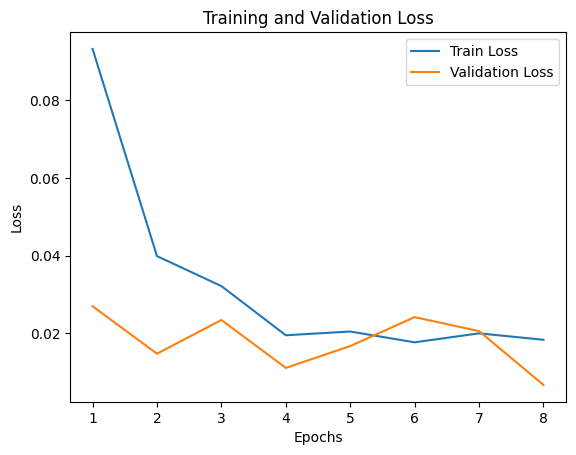

In [75]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)

In [76]:
# Save the model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/FinalProject/trained_model.pth


In [77]:
# Load the trained model
model_path = "/content/drive/MyDrive/FinalProject/trained_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully")

Model loaded successfully


In [78]:
def predict_head_circumference(image_path, model, min_hc, max_hc):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predicted_normalized_hc = model(image).item()
        predicted_hc = predicted_normalized_hc * (max_hc - min_hc) + min_hc  # De-normalize the prediction

    return predicted_hc

In [80]:
# Evaluate the model on the entire training set
min_hc = train_csv_df['head circumference (mm)'].min()
max_hc = train_csv_df['head circumference (mm)'].max()
num_images_to_test = len(train_csv_df)
indices = range(num_images_to_test)  # Generate a sequence of indices from 0 to num_images_to_test-1

# Initialize a list to store the results
results = []
absolute_errors = []
counter = 0
error_parameter = 5

# Variables to track the maximum absolute error and corresponding details
max_absolute_error = -1
max_error_image = ""
max_error_predicted = -1
max_error_ground_truth = -1

# Loop through the selected images
for idx in indices:
    image_name = train_csv_df.iloc[idx, 0]
    image_path = os.path.join("/content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/", image_name)
    ground_truth_circumference = train_csv_df.iloc[idx, 2]  # Assuming the third column contains the head circumference labels

    # Call the function to predict head circumference from the image
    predicted_circumference = predict_head_circumference(image_path, model, min_hc, max_hc)

    # Calculate the absolute error
    absolute_error = abs(predicted_circumference - ground_truth_circumference)
    absolute_errors.append(absolute_error)

    # Track the maximum absolute error
    if absolute_error > max_absolute_error:
        max_absolute_error = absolute_error
        max_error_image = image_path
        max_error_predicted = predicted_circumference
        max_error_ground_truth = ground_truth_circumference

    # Create the result string
    result_string = (f"Image: {image_path}\n"
                     f"Predicted Head Circumference: {predicted_circumference}\n"
                     f"Ground Truth Head Circumference: {ground_truth_circumference}\n"
                     f"Absolute Error: {absolute_error}\n"
                     "****************************\n")

    # Append the result to the list
    results.append([image_name, result_string, absolute_error])

    if absolute_error < error_parameter:
        counter += 1

# Convert the results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(results, columns=['Image', 'Result', 'Absolute Error'])
results_csv_path = "/content/drive/MyDrive/FinalProject/results.csv"
results_df.to_csv(results_csv_path, index=False)

# Print summary
print(f"Results saved to {results_csv_path}")
print(f"Total Images with Error < {error_parameter}: {counter}")
print(f"Percentage: {counter / num_images_to_test * 100:.2f}%")

# Print the image with the biggest absolute error
print("Image with the biggest absolute error:")
print(f"Image: {max_error_image}")
print(f"Predicted Head Circumference: {max_error_predicted}")
print(f"Ground Truth Head Circumference: {max_error_ground_truth}")
print(f"Absolute Error: {max_absolute_error}")


Results saved to /content/drive/MyDrive/FinalProject/results.csv
Total Images with Error < 5: 172
Percentage: 17.22%
Image with the biggest absolute error:
Image: /content/drive/MyDrive/FinalProject/Dataset/training_set/training_set/096_HC.png
Predicted Head Circumference: 175.52300928831096
Ground Truth Head Circumference: 75.64
Absolute Error: 99.88300928831096
